In [334]:
from __future__ import print_function
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import GPy
from pandas import Series, DataFrame
from sklearn.metrics import r2_score
from sklearn import cross_validation
from IPython.core.pylabtools import figsize

%matplotlib inline
figsize(16, 8)

# Load and adjust the data

In [335]:
df_std1 = pd.read_csv('../data/std1_mh_11_pubchem_hmdb.csv', keep_default_na=False)
df_std2 = pd.read_csv('../data/std2_mh_11_pubchem_hmdb.csv', keep_default_na=False)

df_std1.drop(0, axis=0, inplace=True)
df_std1['JCHEM_ACIDIC_PKA'] = df_std1['JCHEM_ACIDIC_PKA'].astype(float)

for df in [df_std1, df_std2]:
#     max_intensity = df['Dil_1_1'].max()
#     df['Dil_1_1'] = df['Dil_1_1'] / max_intensity # * 10000.0
    df['Dil_1_1'] = np.log(df['Dil_1_1'])
    
df = pd.concat([df_std1, df_std2])
df.reset_index(drop=True, inplace=True)

df.head(3)

,Name,Formula,Adduct,Dil_1_1,InChI,InChI_Key,cid,complexity,exact_mass,h_bond_acceptor_count,...,JCHEM_DONOR_COUNT,JCHEM_LOGP,JCHEM_PHYSIOLOGICAL_CHARGE,JCHEM_POLARIZABILITY,JCHEM_POLAR_SURFACE_AREA,JCHEM_REFRACTIVITY,JCHEM_ROTATABLE_BOND_COUNT,IUPAC_NAME,TRADITIONAL_IUPAC_NAME,SYNONYMS
0,Glycerol,C3H8O3,M+H,14.589731,"InChI=1S/C3H8O3/c4-1-3(6)2-5/h3-6H,1-2H2",InChIKey=PEDCQBHIVMGVHV-UHFFFAOYSA-N,753,25.2,92.047344,3,...,3,-1.8,0,8.93,60.69,20.52,2,"propane-1,2,3-triol",glycerol,"1,2,3-Trihydroxypropane;Bulbold;Cristal;E 422;..."
1,Inosine,C10H12N4O5,M+H,18.067768,InChI=1S/C10H12N4O5/c15-1-4-6(16)7(17)10(19-4)...,InChIKey=UGQMRVRMYYASKQ-KQYNXXCUSA-N,6021,405.0,268.080770,6,...,4,-2.5,0,24.48,129.20,61.33,2,"9-[(2R,3R,4S,5R)-3,4-dihydroxy-5-(hydroxymethy...","9-[(2R,3R,4S,5R)-3,4-dihydroxy-5-(hydroxymethy...","(-)-Inosine;1,9-Dihydro-9-b-D-ribofuranosyl-6H..."
2,L-Phenylalanine,C9H11NO2,M+H,18.879302,InChI=1S/C9H11NO2/c10-8(9(11)12)6-7-4-2-1-3-5-...,InChIKey=COLNVLDHVKWLRT-QMMMGPOBSA-N,6140,153.0,165.078979,3,...,2,-1.2,0,17.20,63.32,45.12,3,(2S)-2-amino-3-phenylpropanoic acid,L-phenylalanine,(-)-beta-Phenylalanine;(L)-Phenylalanine;(S)-(...


# Data preparation

In [336]:
features = [
    u'JCHEM_ACIDIC_PKA',
    u'JCHEM_LOGP',
    u'JCHEM_POLARIZABILITY',
    u'JCHEM_POLAR_SURFACE_AREA',
]

features = [
    u'EXACT_MASS', 
    u'ALOGPS_LOGP',
    u'ALOGPS_LOGS', u'MOLECULAR_WEIGHT',
    u'JCHEM_ACCEPTOR_COUNT',
    u'JCHEM_ACIDIC_PKA', u'JCHEM_DONOR_COUNT',
    u'JCHEM_LOGP', u'JCHEM_PHYSIOLOGICAL_CHARGE', u'JCHEM_POLARIZABILITY',
    u'JCHEM_POLAR_SURFACE_AREA', u'JCHEM_REFRACTIVITY',
    u'JCHEM_ROTATABLE_BOND_COUNT'
]

features = [
    u'JCHEM_ACIDIC_PKA',
    u'JCHEM_LOGP',
    u'JCHEM_POLARIZABILITY',
    u'JCHEM_POLAR_SURFACE_AREA',
]

# X_train = df_std1
# y_train = df_std1[['Dil_1_1']]

# X_test = df_std2
# y_test = df_std2[['Dil_1_1']]

X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    df, df[['Dil_1_1']], test_size=0.4, random_state=1)

print("Number of metabolites (training):", len(X_train))
print("Number of metabolites (testing):", len(X_test))

Number of metabolites (training): 54
Number of metabolites (testing): 37


In [337]:
X_train[features].head(3)

,JCHEM_ACIDIC_PKA,JCHEM_LOGP,JCHEM_POLARIZABILITY,JCHEM_POLAR_SURFACE_AREA
59,10.24,-0.27,14.43,66.49
15,1.64,-3.70,12.29,69.56
74,9.83,-1.10,9.88,67.48


# Fit Gaussian Process

In [338]:
kernel = GPy.kern.RBF(len(features), ARD=False)
model = GPy.models.GPRegression(X_train[features], y_train, kernel=kernel, normalizer=True)

model.optimize()

In [339]:
# kernel.lengthscale

In [340]:
# kernel.plot_ARD()

In [341]:
from IPython.display import display
display(model)

# Make predictions

We are making predictions on the same data we used for training, which doesn't seem correct

In [342]:
mu_train, var_train = model.predict(X_train[features].as_matrix())
mu, var = model.predict(X_test[features].as_matrix())

In [343]:
X_test[features].describe()

,JCHEM_ACIDIC_PKA,JCHEM_LOGP,JCHEM_POLARIZABILITY,JCHEM_POLAR_SURFACE_AREA
count,37.000000,37.000000,37.000000,37.000000
mean,5.330541,-1.504270,17.261892,94.243514
std,4.532448,1.623334,6.822840,39.230075
min,0.760000,-4.800000,6.440000,34.140000
25%,2.110000,-2.800000,11.710000,63.320000
50%,3.190000,-1.500000,16.210000,89.340000
75%,9.700000,-0.048000,21.060000,116.950000
max,16.380000,1.830000,30.020000,186.070000


In [344]:
data = pd.concat([X_test, DataFrame(mu, columns=['Prediction'], index=X_test.index)], axis=1)

data[['Name', 'Dil_1_1', 'Prediction']]

,Name,Dil_1_1,Prediction
58,Guanosine,14.128025,17.275308
88,N-Acetylglutamine,19.783245,18.509763
43,IMP,15.616823,17.285770
55,5'-Methylthioadenosine,20.169380,17.314509
73,AMP,13.467667,17.224139
86,Biotin,12.712258,17.825018
60,L-isoleucine,20.153904,18.947638
52,Hypoxanthine,17.977465,19.771953
46,2-oxobutanoate,13.705935,15.822430
39,Uridine,14.312783,17.193545


In [345]:
y_true = data['Dil_1_1']
y_pred_new = data['Prediction']

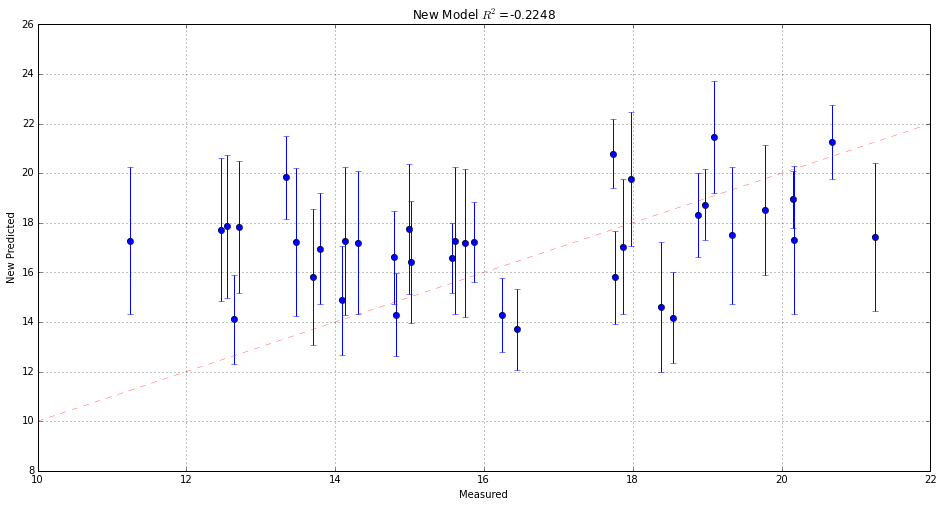

In [346]:
#figsize(8, 8)
plt.clf()
plt.xlabel('Measured')
plt.ylabel('New Predicted')

plt.scatter(y_true, y_pred_new)
plt.errorbar(y_true, y_pred_new, yerr=np.sqrt(var), fmt='o')

xlim = plt.xlim()
plt.plot([xlim[0], xlim[1]], [xlim[0], xlim[1]], 'r--', linewidth=.3)
plt.xlim(*xlim)

plt.grid(True)
plt.title('New Model $R^2$={:.4f}'.format(r2_score(y_true, y_pred_new)))

plt.show()

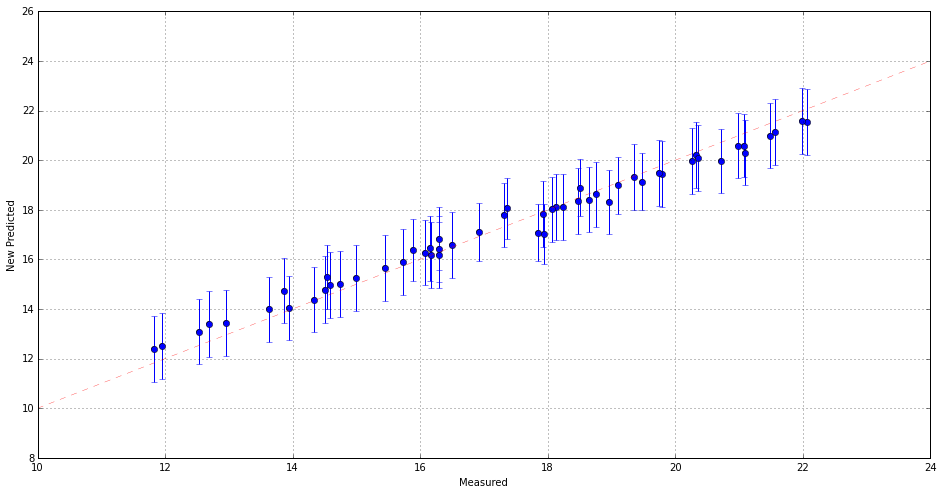

In [347]:
#figsize(8, 8)
plt.clf()
plt.xlabel('Measured')
plt.ylabel('New Predicted')

plt.scatter(y_train['Dil_1_1'], mu_train)
plt.errorbar(y_train['Dil_1_1'], mu_train, yerr=np.sqrt(var_train), fmt='o')


xlim = plt.xlim()
plt.plot([xlim[0], xlim[1]], [xlim[0], xlim[1]], 'r--', linewidth=.3)
plt.xlim(*xlim)

plt.grid(True)

plt.show()